<a href="https://colab.research.google.com/github/venomouscyanide/grl/blob/master/assignment1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install torch geometric
# Takes a good amount of time! Around 14 mins.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric

     |████████████████████████████████| 43 kB 816 kB/s 
     |████████████████████████████████| 308 kB 5.4 MB/s 
     |████████████████████████████████| 407 kB 35.9 MB/s 
     |████████████████████████████████| 45 kB 2.3 MB/s 


# All imports

In [ ]:
import time
from copy import deepcopy
import itertools
import random
from typing import List, Union
from cachetools import Cache
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.datasets import *
from torch_geometric.nn import GCNConv
from torch.nn import Linear
import networkx as nx
from networkx.algorithms.centrality import *
from networkx.algorithms.cluster import *
from torch_geometric.utils import to_networkx
from matplotlib import pyplot as plt

Creating a cache to store the target tensors containing node statistics. Calculating N node statistics(8 in my experiments) multiple times can be compute heavy for graphs with high number of nodes.

In [ ]:
cache = Cache(maxsize=4)

# Utility functions
A few utility functions to help understand the datasets.

In [ ]:
def visualize(h: Union[torch.tensor, nx.Graph], color, epoch: int = None, loss=None):
    """
        Helps visualize the graph in a 2d space
    """
    # Taken from https://colab.research.google.com/drive/1CILdAekIkIh-AX2EXwZ3ZsZ6VcCbwc0t?usp=sharing
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(h, pos=None, with_labels=False, node_color=color, cmap="Dark2")
    plt.show()


def show_dataset_as_networkx_graph(data: Dataset):
    """
        Convert PyG dataset into nx graph for visualization
    """
    G = to_networkx(data, to_undirected=False)
    visualize(G, color=data.y)


def show_dataset_stats(dataset: Dataset):
    """
        Show the stats of the dataset
    """
    # Taken from https://colab.research.google.com/drive/1CILdAekIkIh-AX2EXwZ3ZsZ6VcCbwc0t?usp=sharing
    data = dataset[0]
    print(f'Dataset: {dataset}:')
    print('======================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Number of training nodes: {data.train_mask.sum()}')
    print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
    print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
    print(f'Contains self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')
    print('======================')


# GCN model
A simple GCN model with 3 layers. Outputs a tensor that is  num_nodes * 8 dimensions. 

In [ ]:
class GCN(torch.nn.Module):
    # TODO: multiple regressor heads?
    # reference: https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html

    def __init__(self, dataset: Data):
        super().__init__()

        self.conv1 = GCNConv(dataset.num_node_features, 32)
        self.conv2 = GCNConv(32, 16)
        self.conv3 = GCNConv(16, Hyperparameters.EMBEDDINGS_SIZE)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=Hyperparameters.LEARNING_RATE,
                                          weight_decay=Hyperparameters.WEIGHT_DECAY)
        self.criterion = torch.nn.MSELoss()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)

        x = F.relu(x)
        x = self.conv2(x, edge_index)

        x = F.relu(x)
        x = self.conv3(x, edge_index)

        return x

    def train_helper(self, target: torch.tensor, epoch: int, viz_training: bool, data):
        self.optimizer.zero_grad()
        h = self(data.x, data.edge_index)
        loss = self.criterion(h[data.train_mask], target[data.train_mask])
        loss.backward()
        if viz_training and epoch % 50 == 0:
            print(f"epoch: {epoch}, loss: {loss}")
        self.optimizer.step()


# Class for capturing node statistics in a tensor
Calculate the node features based on nx APIs. I capture 8 different statistical properties for each node in the graph. The captured features are then converted into a tensor to be used during training.

In [ ]:
class CreateNodeFeatureTensor:
    def create(self, data: Data):
        """
            For the nodes in the dataset, create a tensor of num_nodes * 8, where each node has 8 dimensions.
            Each dimension corresponds to a node statistic.
        """
        dataset_id = str(data)
        if type(cache.get(dataset_id)) == torch.Tensor:
            return cache.get(dataset_id)
        nx_graph = to_networkx(data)
        random.seed(13)
        # features captured. Random sampling is kind of useless as the seed is fixed and all the population is sampled.
        # this was written for future work and would work well without sampling at all.
        feature_functions: List[str] = random.sample(Hyperparameters.ALL_STATISTICS_CAPTURED,
                                                     Hyperparameters.EMBEDDINGS_SIZE)
        # ref for globals()["function_name"](): https://stackoverflow.com/a/834451
        feature_values: List[List[float]] = [
            list(globals()[feature](nx_graph).values()) for feature in feature_functions
        ]
        features = [list(node_embedding) for node_embedding in zip(*feature_values)]
        target_tensor = torch.tensor(features, dtype=torch.float)
        cache[dataset_id] = target_tensor
        return target_tensor

# Setting the hyperparameters
This class contains the hyperparameter configurations for training. It also contains a method to overwrite the default parameters to perform automated analysis.

In [ ]:
class Hyperparameters:
    # Ref for centrality APIs: https://networkx.org/documentation/stable/reference/algorithms/centrality.html
    # Ref for clustering APIs: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html
    # I just focus on learning centrality/clustering related info
    # target tensor size is 8
    ALL_STATISTICS_CAPTURED: List[str] = ['degree_centrality', 'in_degree_centrality',
                                          'eigenvector_centrality', 'harmonic_centrality',
                                          'closeness_centrality', 'betweenness_centrality', 'load_centrality',
                                          'clustering']
    # upto 8 dimensional vector captured for each node.
    # Each dimension corresponds to a centrality measure in the same order as they are listed above
    # NOTE! This class contains the default values. During automated training and eval, these are overwritten to the automated running config.
    EMBEDDINGS_SIZE: int = 8
    LEARNING_RATE: float = 0.01
    WEIGHT_DECAY: float = 1e-5
    TRAINING_RATIO: float = 0.70
    DATASET: str = "KarateClub"
    EPOCHS: int = 1000
    ERROR_THRESHOLD: torch.FloatTensor = torch.FloatTensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 10])

    @staticmethod
    def override_defaults(*args):
        """
            this method allows you to override the defaults for automated testing on different configs.
        """
        Hyperparameters.EMBEDDINGS_SIZE = args[0]
        Hyperparameters.LEARNING_RATE = args[1]
        Hyperparameters.WEIGHT_DECAY = args[2]
        Hyperparameters.TRAINING_RATIO = args[3]
        Hyperparameters.DATASET = args[4]
        Hyperparameters.EPOCHS = args[5]

# Class to help train the model on the dataset of choice
The TrainAndEvaluate class will run training on the Hyperparameters set in Hyperparameters. It also has an evaluate() endpoint to return the accuracy after training

In [ ]:
class TrainAndEvaluate:
    """
        This class is responsible for two things:
            1) Run the training for N epochs on a dataset
            2) Report the accuracy after training
    """
    def __init__(self, data: Dataset):
        self.data = data
        self.target = CreateNodeFeatureTensor().create(data)

    def train_helper(self, viz_data: bool = False, viz_training: bool = False):
        if viz_data:
            show_dataset_as_networkx_graph(self.data)
        self._set_train_test_mask()
        model = GCN(self.data)
        for epoch in range(Hyperparameters.EPOCHS):
            model.train_helper(self.target, epoch, viz_training, self.data)
        return model

    def evaluate(self, trained_model: GCN) -> float:
        trained_model.eval()
        out_tensor = trained_model(self.data.x, self.data.edge_index)
        return self._get_accuracy(out_tensor)

    def _set_train_test_mask(self):
        # set train and test mask according to how you set the training ratio hyperparameter. 
        # Having this helps you tune the amount of nodes you want to expose during training/testing phases.
        set_of_all_indices = set(range(len(self.data.x)))

        train_mask_indices = torch.randperm(len(self.data.x))[:int(Hyperparameters.TRAINING_RATIO * len(self.data.x))]
        set_of_training_indices = set(train_mask_indices.detach().tolist())
        test_mask_indices = torch.tensor(list(set_of_all_indices.difference(set_of_training_indices)), dtype=int)

        train_mask = torch.tensor([False for _ in range(len(self.data.x))], dtype=bool)
        test_mask = torch.tensor([False for _ in range(len(self.data.x))], dtype=bool)

        train_mask[train_mask_indices] = True
        test_mask[test_mask_indices] = True

        # sanity check
        assert len(set_of_training_indices.intersection(set(test_mask_indices.detach().tolist()))) == 0 \
            , "train and test sets are not mutually exclusive"

        # overwrite the test and train boolean masks
        self.data.test_mask = test_mask
        self.data.train_mask = train_mask

    def _get_accuracy(self, out: torch.tensor) -> float:
        # TODO: for some reason cosine sim is giving high similarity no matter what. Find out why.
        # cosine_sim = torch.nn.functional.cosine_similarity(x1=out[self.data.test_mask],
        #                                                    x2=self.target[self.data.test_mask], dim=1)
        # As a result, define a custom accuracy metric
        # all the output values must be within the threshold defined in Hyperparameters.ERROR_THRESHOLD
        # for eg: if the output for the node X is [0.6, 0.5, 0.5, 10], actual value is [0.4, 0.9, 0.7, 15] error threshold is set to [0.3, 0.1, 0.2, 3]
        # we find absolute difference between prediction and expected. abs([0.6, 0.5, 0.5, 10] - [0.4, 0.9, 0.7, 15]) => [0.2, 0.4, 0.2, 5]. 
        # This gives us [True, False, True, False]. Ie; calculate all values which are less than or equal to the values in the threshold
        # Thus accuracy for this node is 2/4 = 50%. Likewise calculate across all the nodes.
        # accuracy = num_of_node_stats_within_threshold_for_all_nodes / (num_nodes * node_dimension) * 100
        # Do note that the accuracy is calculated across all the test nodes

        diff_tensor = torch.abs(out[self.data.test_mask] - self.target[self.data.test_mask])
        within_threshold = torch.le(diff_tensor, Hyperparameters.ERROR_THRESHOLD)
        numerator = int(torch.count_nonzero(within_threshold == True))
        denominator = diff_tensor.shape[0] * diff_tensor.shape[1]
        accuracy = round(numerator / denominator * 100, 4)
        return accuracy


# Class to automate the training and to summarize the results into a dataframe
A class to automate the training on different configurations and capture the result in a dataframe.

In [ ]:
class TrainAndCaptureResults:
    """
        Helps run different combinations of hyperparameters as captured in HyperParameterCombinations.
        For each combination, take the average accuracy over 3 predefined random seeds and add to dataframe.
        At the end of execution, you will have a N row dataframe, where N = number of combinations.
        The dataframe is ordered in descending order of average accuracy to find out the best combination.
    """
    def __init__(self):
        self.seeds: List[int] = [7, 13, 23]
        self.data = pd.DataFrame(
            columns=["Embedding Size", "Learning Rate", "Weight Decay", "Training Ratio", "Dataset", "Epochs",
                     "Error Threshold", "Avg Accuracy"])

    def _setup(self) -> List:
        combinations = [HyperParameterCombinations.ES, HyperParameterCombinations.LR, HyperParameterCombinations.WD,
                        HyperParameterCombinations.TR, HyperParameterCombinations.DATASET,
                        HyperParameterCombinations.EPOCHS,
                        HyperParameterCombinations.ET]
        return combinations

    def run(self):
        """
            run all the combinations and return the created dataframe with the results
        """
        accuracies = []
        all_combinations = list(itertools.product(*self._setup()))
        total_combinations = len(all_combinations)
        print(f"Total combinations to run exp on: {total_combinations}")
        for index, combination in enumerate(all_combinations):
            print(f"Running combination: {index + 1} of {total_combinations}")
            combination = list(combination)
            data = combination[4]
            accuracy_sum = 0.0
            Hyperparameters.override_defaults(*combination)
            for seed in self.seeds:
                torch.manual_seed(seed)
                train_and_eval = TrainAndEvaluate(data[0])
                trained_model = train_and_eval.train_helper(False)
                accuracy_sum += train_and_eval.evaluate(trained_model)
            avg_accuracy = round(accuracy_sum / 3, 4)
            accuracies.append(avg_accuracy)
            combination.append(avg_accuracy)
            combination[4] = str(combination[4])
            self.data.loc[len(self.data)] = combination
        best_accuracy = max(accuracies)
        print(f"Best accuracy: {best_accuracy}")
        self.data.sort_values(by="Avg Accuracy", ascending=False, inplace=True)
        return self.data

# Experiments
Conduct different experiments on small/medium sized graphs to see the accuracy after training.

## Experiment on KarateClub dataset
Before each experiment it is vital to define the class HyperParameterCombinations which will contain all the values on which the experiments are to be conducted on. 

In [ ]:
show_dataset_stats(KarateClub())

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


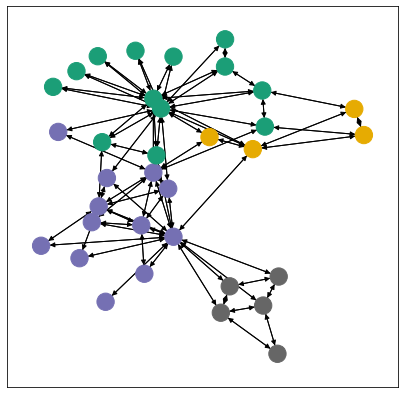

In [ ]:
show_dataset_as_networkx_graph(KarateClub()[0])

In [ ]:
class HyperParameterCombinations:
    """
    To be manually configured
    """
    ES = [8]
    LR = [0.01, 0.001]
    WD = [1e-5, 1e-3]
    TR = [x / 10 for x in range(1, 9)]
    DATASET = [KarateClub()]
    EPOCHS = [250, 500, 1000]
    ET = [torch.FloatTensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 10])]

In [ ]:
df = TrainAndCaptureResults().run()

Total combinations to run exp on: 96
Running combination: 1 of 96
Running combination: 2 of 96
Running combination: 3 of 96
Running combination: 4 of 96
Running combination: 5 of 96
Running combination: 6 of 96
Running combination: 7 of 96
Running combination: 8 of 96
Running combination: 9 of 96
Running combination: 10 of 96
Running combination: 11 of 96
Running combination: 12 of 96
Running combination: 13 of 96
Running combination: 14 of 96
Running combination: 15 of 96
Running combination: 16 of 96
Running combination: 17 of 96
Running combination: 18 of 96
Running combination: 19 of 96
Running combination: 20 of 96
Running combination: 21 of 96
Running combination: 22 of 96
Running combination: 23 of 96
Running combination: 24 of 96
Running combination: 25 of 96
Running combination: 26 of 96
Running combination: 27 of 96
Running combination: 28 of 96
Running combination: 29 of 96
Running combination: 30 of 96
Running combination: 31 of 96
Running combination: 32 of 96
Running comb

In [ ]:
df

Embedding Size  ...  Avg Accuracy
43              8  ...       90.1515
44              8  ...       89.7727
40              8  ...       89.2857
22              8  ...       89.2857
19              8  ...       89.0152
..            ...  ...           ...
48              8  ...       64.5161
8               8  ...       64.4097
5               8  ...       64.1369
2               8  ...       63.9785
1               8  ...       63.0376

[96 rows x 8 columns]

## Experiment on the Cora Dataset

In [ ]:
show_dataset_stats(Planetoid(root="delete_me/", name="Cora"))

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


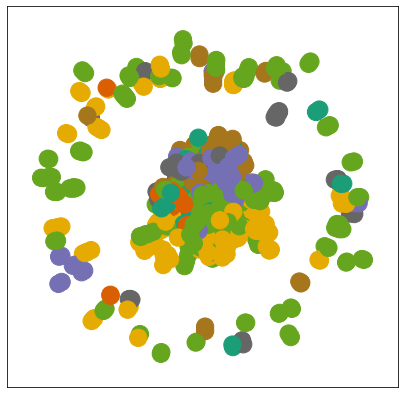

In [ ]:
show_dataset_as_networkx_graph(Planetoid(root="delete_me/", name="Cora")[0])

In [ ]:
class HyperParameterCombinations:
    """
    To be manually configured
    """
    ES = [8]
    LR = [0.01, 0.001]
    WD = [1e-5, 1e-3]
    TR = [x / 10 for x in range(1, 9)]
    DATASET = [Planetoid(root="delete_me/", name="Cora")]
    EPOCHS = [250, 500, 1000]
    ET = [torch.FloatTensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 10])]

In [ ]:
df = TrainAndCaptureResults().run()

Total combinations to run exp on: 96
Running combination: 1 of 96
Running combination: 2 of 96
Running combination: 3 of 96
Running combination: 4 of 96
Running combination: 5 of 96
Running combination: 6 of 96
Running combination: 7 of 96
Running combination: 8 of 96
Running combination: 9 of 96
Running combination: 10 of 96
Running combination: 11 of 96
Running combination: 12 of 96
Running combination: 13 of 96
Running combination: 14 of 96
Running combination: 15 of 96
Running combination: 16 of 96
Running combination: 17 of 96
Running combination: 18 of 96
Running combination: 19 of 96
Running combination: 20 of 96
Running combination: 21 of 96
Running combination: 22 of 96
Running combination: 23 of 96
Running combination: 24 of 96
Running combination: 25 of 96
Running combination: 26 of 96
Running combination: 27 of 96
Running combination: 28 of 96
Running combination: 29 of 96
Running combination: 30 of 96
Running combination: 31 of 96
Running combination: 32 of 96
Running comb

In [ ]:
df

Embedding Size  ...  Avg Accuracy
51              8  ...       72.3043
63              8  ...       71.7136
84              8  ...       71.6457
69              8  ...       71.2331
93              8  ...       71.1947
..            ...  ...           ...
18              8  ...       32.5748
31              8  ...       31.9928
47              8  ...       31.7036
17              8  ...       30.4428
34              8  ...       30.3744

[96 rows x 8 columns]

## Experiment on Citeceer Dataset

In [ ]:
show_dataset_stats(Planetoid(root="delete_me/", name="CiteSeer"))

Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6
Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Number of training nodes: 120
Training node label rate: 0.04
Contains isolated nodes: True
Contains self-loops: False
Is undirected: True


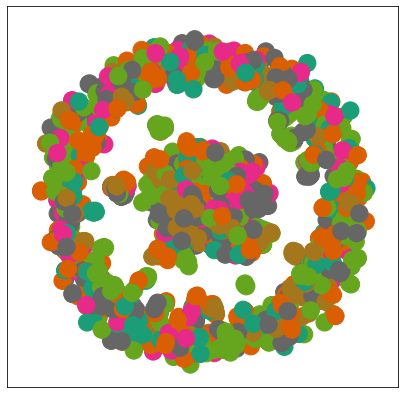

In [ ]:
show_dataset_as_networkx_graph(Planetoid(root="delete_me/", name="CiteSeer")[0])

In [ ]:
class HyperParameterCombinations:
    """
    To be manually configured
    """
    ES = [8]
    LR = [0.01, 0.001]
    WD = [1e-5, 1e-3]
    TR = [x / 10 for x in range(1, 9)]
    DATASET = [Planetoid(root="delete_me/", name="CiteSeer")]
    EPOCHS = [250, 500, 1000]
    ET = [torch.FloatTensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 10])]

In [ ]:
df = TrainAndCaptureResults().run()

Total combinations to run exp on: 96
Running combination: 1 of 96
Running combination: 2 of 96
Running combination: 3 of 96
Running combination: 4 of 96
Running combination: 5 of 96
Running combination: 6 of 96
Running combination: 7 of 96
Running combination: 8 of 96
Running combination: 9 of 96
Running combination: 10 of 96
Running combination: 11 of 96
Running combination: 12 of 96
Running combination: 13 of 96
Running combination: 14 of 96
Running combination: 15 of 96
Running combination: 16 of 96
Running combination: 17 of 96
Running combination: 18 of 96
Running combination: 19 of 96
Running combination: 20 of 96
Running combination: 21 of 96
Running combination: 22 of 96
Running combination: 23 of 96
Running combination: 24 of 96
Running combination: 25 of 96
Running combination: 26 of 96
Running combination: 27 of 96
Running combination: 28 of 96
Running combination: 29 of 96
Running combination: 30 of 96
Running combination: 31 of 96
Running combination: 32 of 96
Running comb

In [ ]:
df

Embedding Size  ...  Avg Accuracy
27              8  ...       71.4172
33              8  ...       70.9919
36              8  ...       70.3601
45              8  ...       69.6071
30              8  ...       69.3001
..            ...  ...           ...
54              8  ...       33.2367
69              8  ...       32.5638
57              8  ...       31.2177
66              8  ...       31.1395
63              8  ...       29.2355

[96 rows x 8 columns]

## Experiment on WebKB datasets

### Wisconsin

In [ ]:
show_dataset_stats(WebKB(root="delete_me/", transform=None, pre_transform=None, name="Wisconsin"))

Dataset: wisconsin():
Number of graphs: 1
Number of features: 1703
Number of classes: 5
Number of nodes: 251
Number of edges: 515
Average node degree: 2.05
Number of training nodes: 1200
Training node label rate: 4.78
Contains isolated nodes: True
Contains self-loops: True
Is undirected: False


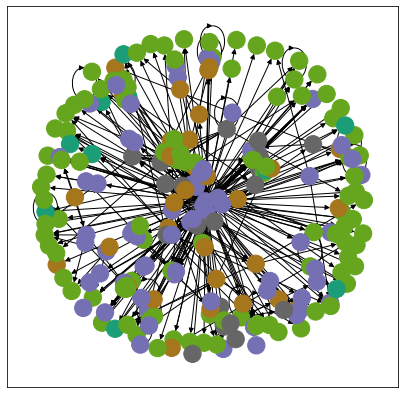

In [ ]:
show_dataset_as_networkx_graph(WebKB(root="delete_me/", transform=None, pre_transform=None, name="Wisconsin")[0])

In [ ]:
class HyperParameterCombinations:
    """
    To be manually configured
    """
    ES = [8]
    LR = [0.01, 0.001]
    WD = [1e-5, 1e-3]
    TR = [x / 10 for x in range(1, 9)]
    DATASET = [WebKB(root="delete_me/", transform=None, pre_transform=None, name="Wisconsin")]
    EPOCHS = [250, 500, 1000]
    ET = [torch.FloatTensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 10])]

In [ ]:
df = TrainAndCaptureResults().run()

Total combinations to run exp on: 96
Running combination: 1 of 96
Running combination: 2 of 96
Running combination: 3 of 96
Running combination: 4 of 96
Running combination: 5 of 96
Running combination: 6 of 96
Running combination: 7 of 96
Running combination: 8 of 96
Running combination: 9 of 96
Running combination: 10 of 96
Running combination: 11 of 96
Running combination: 12 of 96
Running combination: 13 of 96
Running combination: 14 of 96
Running combination: 15 of 96
Running combination: 16 of 96
Running combination: 17 of 96
Running combination: 18 of 96
Running combination: 19 of 96
Running combination: 20 of 96
Running combination: 21 of 96
Running combination: 22 of 96
Running combination: 23 of 96
Running combination: 24 of 96
Running combination: 25 of 96
Running combination: 26 of 96
Running combination: 27 of 96
Running combination: 28 of 96
Running combination: 29 of 96
Running combination: 30 of 96
Running combination: 31 of 96
Running combination: 32 of 96
Running comb

In [ ]:
df

Embedding Size  ...  Avg Accuracy
47              8  ...       92.7288
41              8  ...       92.5330
23              8  ...       92.2386
32              8  ...       92.1165
29              8  ...       92.1020
..            ...  ...           ...
72              8  ...       69.2478
49              8  ...       69.0450
51              8  ...       66.9569
52              8  ...       66.8740
48              8  ...       66.2057

[96 rows x 8 columns]

### Texas

In [ ]:
show_dataset_stats(WebKB(root="delete_me/", transform=None, pre_transform=None, name="Texas"))

Dataset: texas():
Number of graphs: 1
Number of features: 1703
Number of classes: 5
Number of nodes: 183
Number of edges: 325
Average node degree: 1.78
Number of training nodes: 870
Training node label rate: 4.75
Contains isolated nodes: True
Contains self-loops: True
Is undirected: False


Processing...
Done!


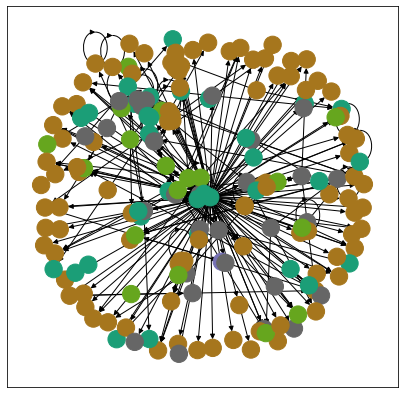

In [ ]:
show_dataset_as_networkx_graph(WebKB(root="delete_me/", transform=None, pre_transform=None, name="Texas")[0])

In [ ]:
class HyperParameterCombinations:
    """
    To be manually configured
    """
    ES = [8]
    LR = [0.01, 0.001]
    WD = [1e-5, 1e-3]
    TR = [x / 10 for x in range(1, 9)]
    DATASET = [WebKB(root="delete_me/", transform=None, pre_transform=None, name="Texas")]
    EPOCHS = [250, 500, 1000]
    ET = [torch.FloatTensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 10])]

In [ ]:
df = TrainAndCaptureResults().run()

Total combinations to run exp on: 96
Running combination: 1 of 96


PowerIterationFailedConvergence: ignored

Ignoring Texas as it requires a different setting in using nx APIs!

### Cornell

In [ ]:
show_dataset_stats(WebKB(root="delete_me/", transform=None, pre_transform=None, name="Cornell"))

Processing...


Dataset: cornell():
Number of graphs: 1
Number of features: 1703
Number of classes: 5
Number of nodes: 183
Number of edges: 298
Average node degree: 1.63
Number of training nodes: 870
Training node label rate: 4.75
Contains isolated nodes: True
Contains self-loops: True
Is undirected: False


Done!


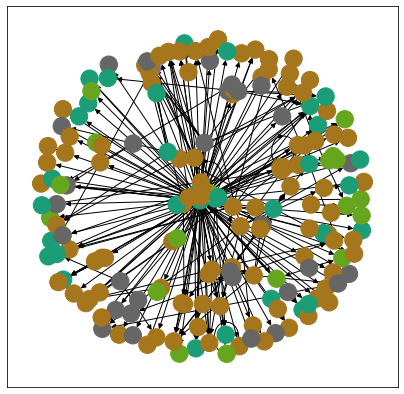

In [ ]:
show_dataset_as_networkx_graph(WebKB(root="delete_me/", transform=None, pre_transform=None, name="Cornell")[0])

In [ ]:
class HyperParameterCombinations:
    """
    To be manually configured
    """
    ES = [8]
    LR = [0.01, 0.001]
    WD = [1e-5, 1e-3]
    TR = [x / 10 for x in range(1, 9)]
    DATASET = [WebKB(root="delete_me/", transform=None, pre_transform=None, name="Cornell")]
    EPOCHS = [250, 500, 1000]
    ET = [torch.FloatTensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 10])]

In [ ]:
df = TrainAndCaptureResults().run()

Total combinations to run exp on: 96
Running combination: 1 of 96
Running combination: 2 of 96
Running combination: 3 of 96
Running combination: 4 of 96
Running combination: 5 of 96
Running combination: 6 of 96
Running combination: 7 of 96
Running combination: 8 of 96
Running combination: 9 of 96
Running combination: 10 of 96
Running combination: 11 of 96
Running combination: 12 of 96
Running combination: 13 of 96
Running combination: 14 of 96
Running combination: 15 of 96
Running combination: 16 of 96
Running combination: 17 of 96
Running combination: 18 of 96
Running combination: 19 of 96
Running combination: 20 of 96
Running combination: 21 of 96
Running combination: 22 of 96
Running combination: 23 of 96
Running combination: 24 of 96
Running combination: 25 of 96
Running combination: 26 of 96
Running combination: 27 of 96
Running combination: 28 of 96
Running combination: 29 of 96
Running combination: 30 of 96
Running combination: 31 of 96
Running combination: 32 of 96
Running comb

In [ ]:
df

Embedding Size  ...  Avg Accuracy
43              8  ...       95.4545
44              8  ...       95.2273
47              8  ...       95.0450
38              8  ...       94.8822
42              8  ...       94.6212
..            ...  ...           ...
55              8  ...       76.5504
48              8  ...       76.1869
49              8  ...       75.1768
50              8  ...       74.5455
56              8  ...       74.4832

[96 rows x 8 columns]

# Test the node embeddings against downstream tasks

To test if the node embeddings learnt from nx stats make sense, I do three tasks on each dataset on the task of node classification.

1.   Get the node classification accuracy when the data.x values are default(one hot encoded)
2.   Get the node classification accuracy when the data.x values are overridden by a manually created tensor of 8 dimensions using nx(where each dimension captures a node statistic)
3.   Train the node statistic learning model(from previous section) on the best observed hyperparameter setting(take one of the top rows from the dataframe of tests run) to get the node embeddings(8 d). Then, override data.x to this learnt node embeddings and perform node classification. This should ideally perform as good as the manually curated data from step 2.


Doing these experiments should tell us if: 

1.   Using raw nx stats tensor in data.x works?
2.   Will the learnt nx stats vector from the previous model work as well as nx stats tensor in the task of node classification?

The experiments are conducted on Cora, CiteSeer and KarateClub and the output is captured in a pd dataframe.
PS: I omit the WebKB datasets as I am not able to make sense of their training and set masks(2d for some reason) 




## Setup the GCN for node classification
Parts here are mostly borrowed from https://colab.research.google.com/drive/16tqEHKOLUgYvXKx1V3blfYGpQb1_09MG?usp=sharing

In [ ]:
class GCNClassification(torch.nn.Module):
    def __init__(self, dataset, dim=None):
        dataset = dataset
        dim = dataset.num_features if not dim else dim
        super(GCNClassification, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dim, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

In [ ]:
def train(data, optimizer, model, criterion):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask],
                     data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

In [ ]:
def train_helper(model, data):
    criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

    for epoch in range(401):
        loss, h = train(data, optimizer, model, criterion)
        # Visualize the node embeddings every 10 epochs
        if epoch % 50 == 0:
            visualize(h, color=data.y, epoch=epoch, loss=loss)

            time.sleep(0.3)

## Setup the comparison class

In [ ]:
class CompareTriplets:
    """
        Given a dataset this class will perform the 3 experiments detailed above and return the df containing the results
    """
    def __init__(self, dataset: Dataset):
        self.dataset = dataset
        self.data = self.dataset[0]
        self.df = pd.DataFrame(columns=["Dataset", "Method", "Accuracy"])

    def _get_accuracy(self, model: GCN, data) -> float:
        with torch.no_grad():
            model_output, h = model(data.x, data.edge_index)
            num = int(
                torch.count_nonzero(
                    torch.argmax(model_output[~ data.train_mask], dim=1) == data.y[~ data.train_mask])
            )
            denom = int(torch.count_nonzero(~ data.train_mask))
            return round(num / denom * 100, 4)

    def execute(self) -> pd.DataFrame:
        print("Training Vanilla")
        vanilla_accuracy = self._run_vanilla_x()
        self.df.loc[len(self.df)] = [str(self.dataset), "Vanilla Implementation", vanilla_accuracy]
        
        print("Training Pure nx stat implementation")
        nx_accuracy = self._run_nx_stat_x()
        self.df.loc[len(self.df)] = [str(self.dataset), "Pure NX Stats Implementation", nx_accuracy]
        
        print("Training learnt nx stat implementation")
        model_stat_accuracy = self._run_model_stat_x()
        self.df.loc[len(self.df)] = [str(self.dataset), "Learnt NX Stats Implementation", model_stat_accuracy]
        
        return self.df

    def _run_vanilla_x(self):
        dataset = deepcopy(self.dataset)
        model = GCNClassification(dataset=dataset)
        data = deepcopy(self.data)
        train_helper(model, data)
        _, h = model(data.x, data.edge_index)
        accuracy = self._get_accuracy(model, data)
        return accuracy

    def _run_nx_stat_x(self):
        dataset = deepcopy(self.dataset)
        data = deepcopy(self.data)
        model = GCNClassification(dataset=dataset, dim=8)
        x = CreateNodeFeatureTensor().create(data)
        data.x = x
        train_helper(model, data)
        _, h = model(data.x, data.edge_index)
        accuracy = self._get_accuracy(model, data)
        return accuracy

    def _run_model_stat_x(self):
        dataset = deepcopy(self.dataset)
        model = GCNClassification(dataset=dataset, dim=8)
        data = deepcopy(self.data)

        train_and_eval = TrainAndEvaluate(data)
        trained_model = train_and_eval.train_helper(False)
        accuracy = train_and_eval.evaluate(trained_model)
        print(f"Node statistics learning accuracy: {accuracy}")

        trained_model.eval()
        copy_data = deepcopy(self.data)
        copy_data.x = trained_model(data.x, data.edge_index).detach()

        train_helper(model, copy_data)
        _, h = model(copy_data.x, copy_data.edge_index)
        accuracy = self._get_accuracy(model, copy_data)
        return accuracy


## Compare node embeddings on KarateClub()

In [ ]:
class Hyperparameters:
    """
        Setting the best hyperparameters observed during experiments on the node embedding learning model on KarateClub
    """
    ALL_STATISTICS_CAPTURED: List[str] = ['degree_centrality', 'in_degree_centrality',
                                          'eigenvector_centrality', 'harmonic_centrality',
                                          'closeness_centrality', 'betweenness_centrality', 'load_centrality',
                                          'clustering']

    EMBEDDINGS_SIZE: int = 8
    LEARNING_RATE: float = 0.010
    WEIGHT_DECAY: float = 0.00100
    TRAINING_RATIO: float = 0.70
    DATASET: str = "KarateClub"
    EPOCHS: int = 500
    ERROR_THRESHOLD: torch.FloatTensor = torch.FloatTensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 10])

Training Vanilla


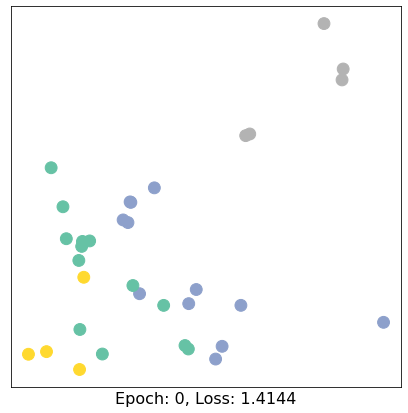

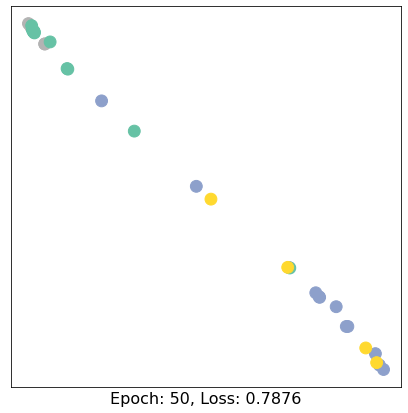

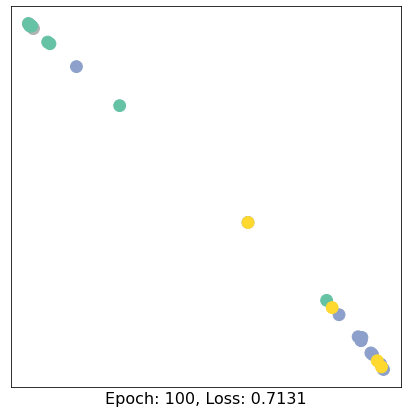

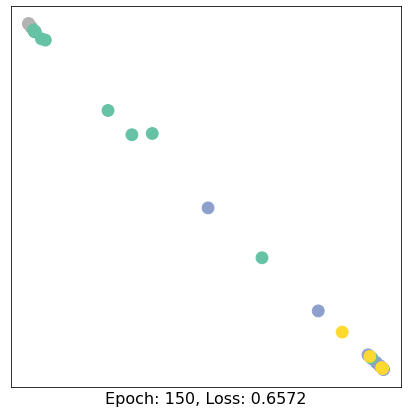

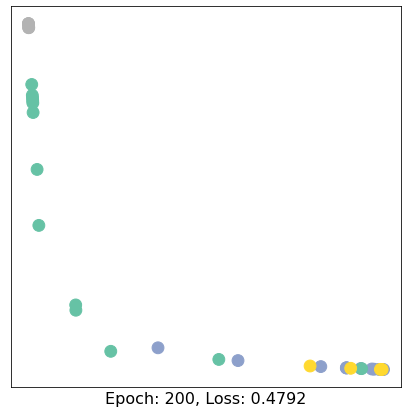

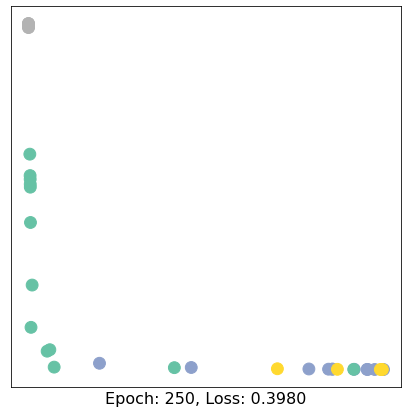

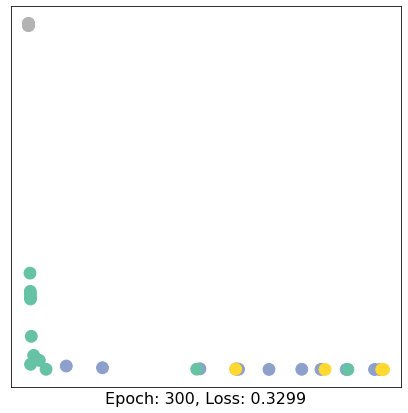

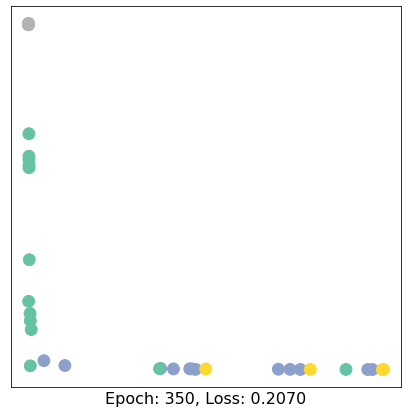

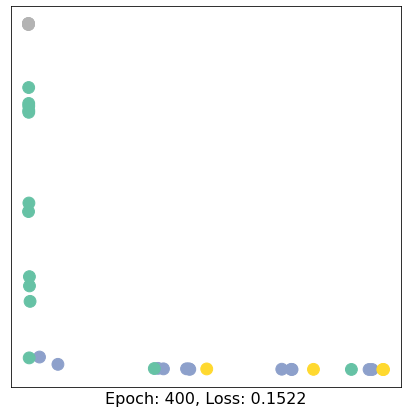

Training Pure nx stat implementation


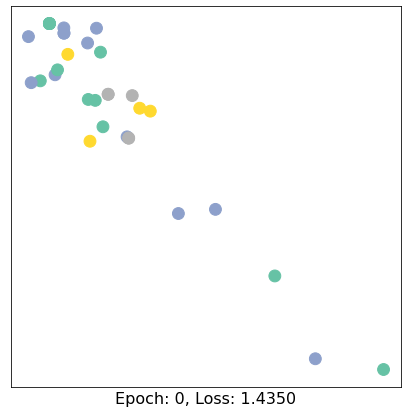

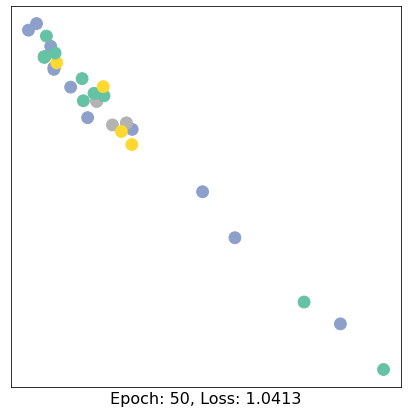

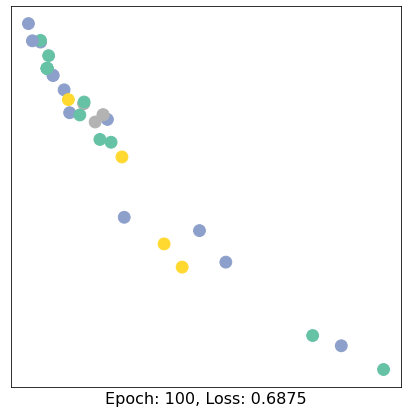

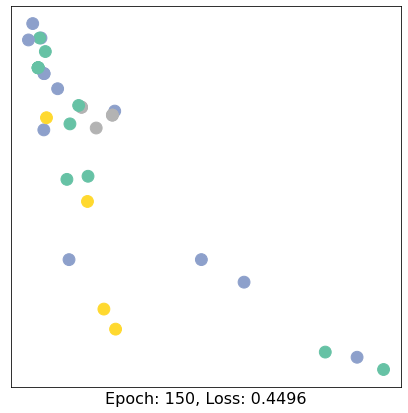

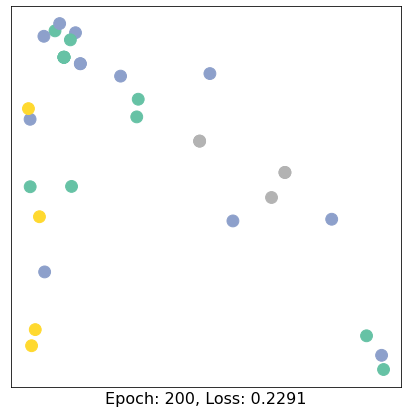

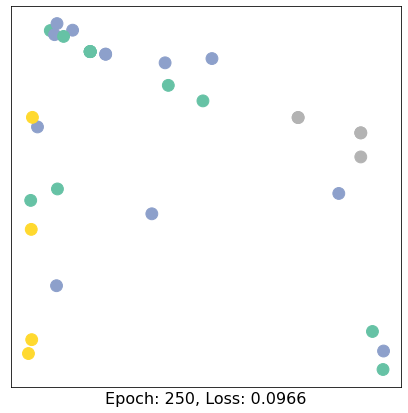

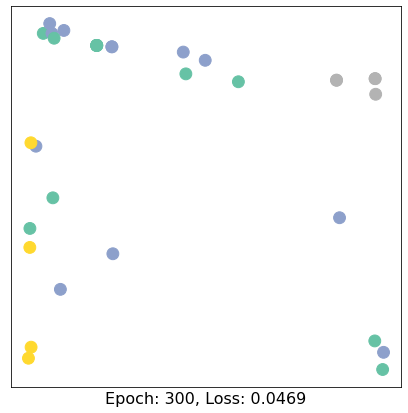

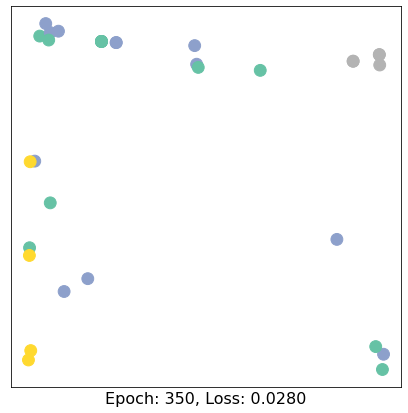

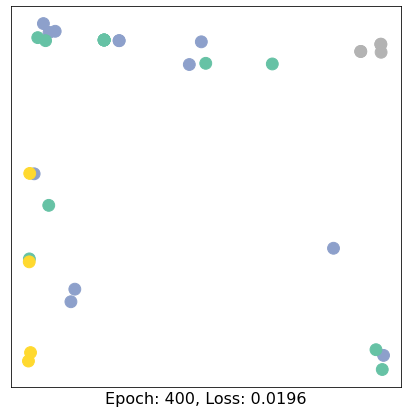

Training learnt nx stat implementation
Node statistics learning accuracy: 82.9545


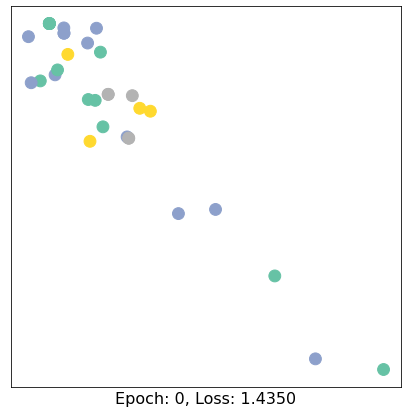

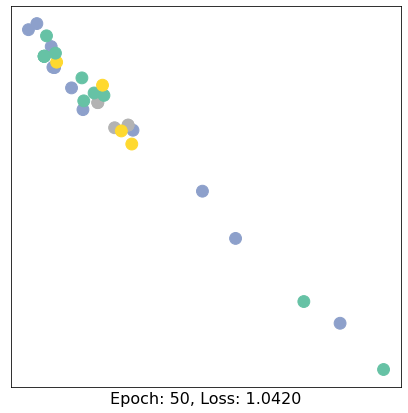

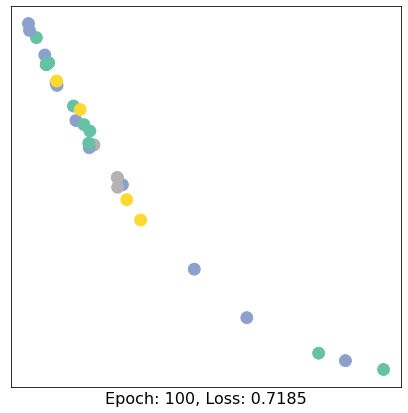

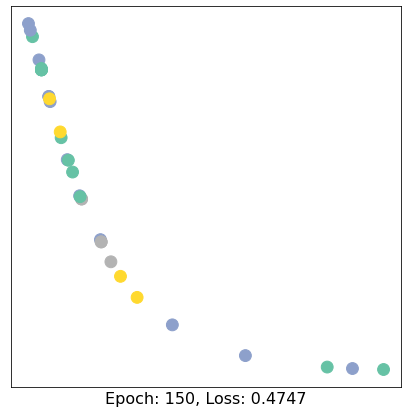

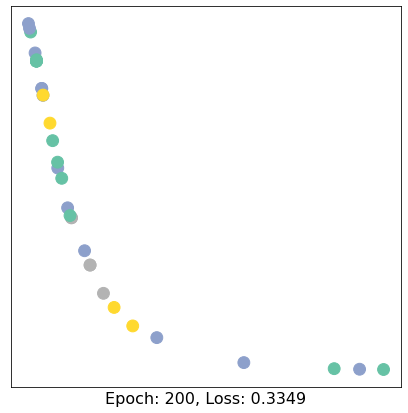

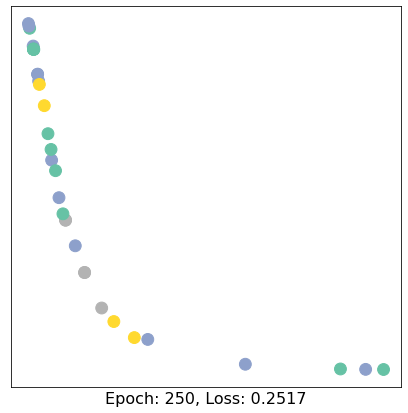

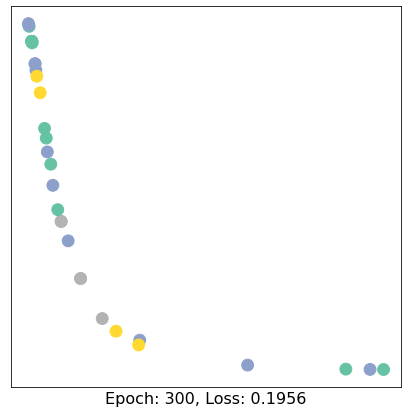

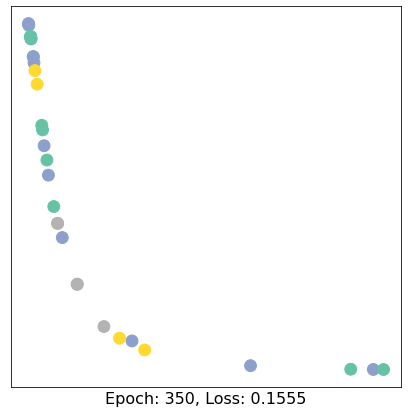

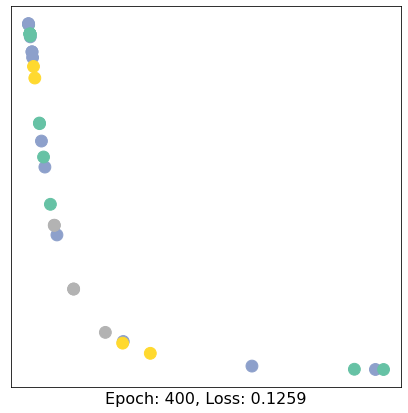

Dataset                          Method  Accuracy
0  KarateClub()          Vanilla Implementation   53.3333
1  KarateClub()    Pure NX Stats Implementation   43.3333
2  KarateClub()  Learnt NX Stats Implementation   40.0000

In [ ]:
CompareTriplets(KarateClub()).execute()

## Compare node embeddings on Cora

In [ ]:
class Hyperparameters:
    """
        Setting the best hyperparameters observed during experiments on the node embedding learning model on Cora
    """
    ALL_STATISTICS_CAPTURED: List[str] = ['degree_centrality', 'in_degree_centrality',
                                          'eigenvector_centrality', 'harmonic_centrality',
                                          'closeness_centrality', 'betweenness_centrality', 'load_centrality',
                                          'clustering']

    EMBEDDINGS_SIZE: int = 8
    LEARNING_RATE: float = 0.0010
    WEIGHT_DECAY: float = 0.00001 	
    TRAINING_RATIO: float = 0.7
    DATASET: str = "Cora"
    EPOCHS: int = 250
    ERROR_THRESHOLD: torch.FloatTensor = torch.FloatTensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 10])

Training Vanilla


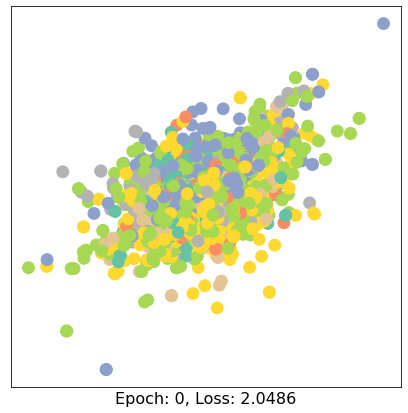

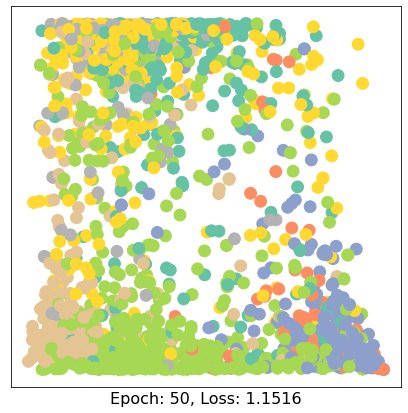

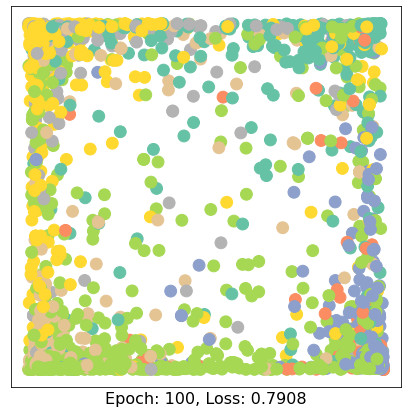

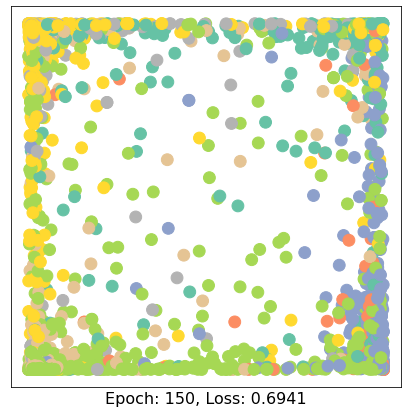

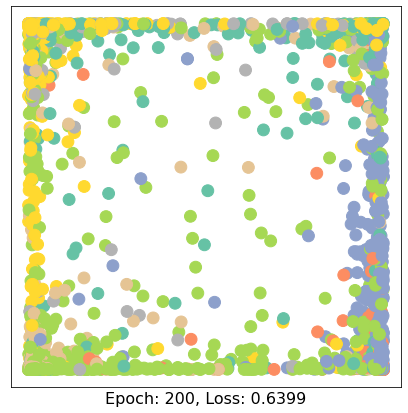

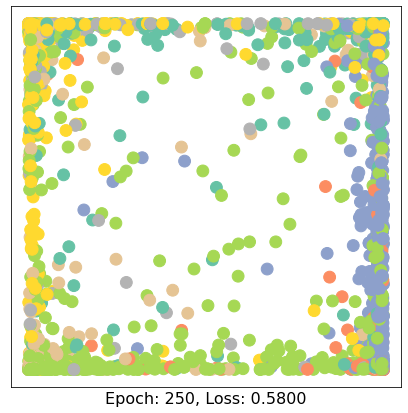

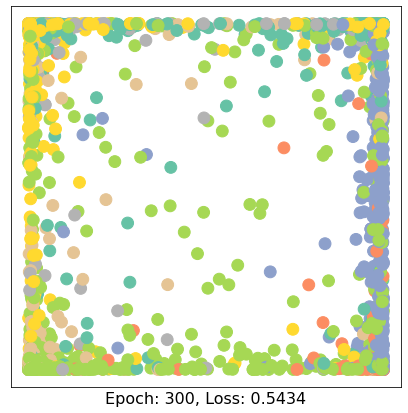

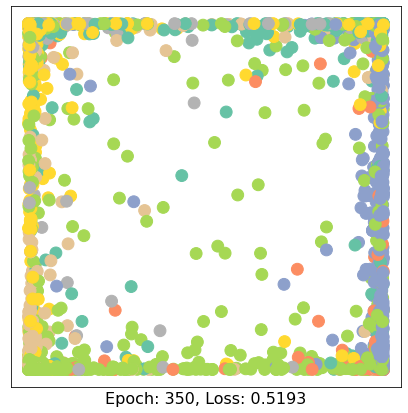

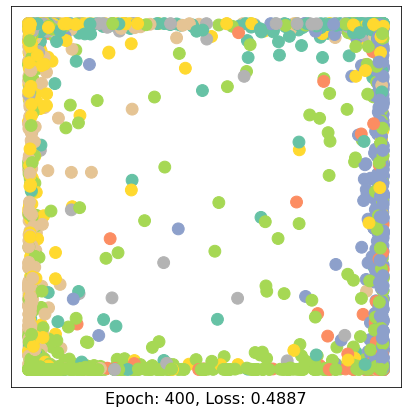

Training Pure nx stat implementation


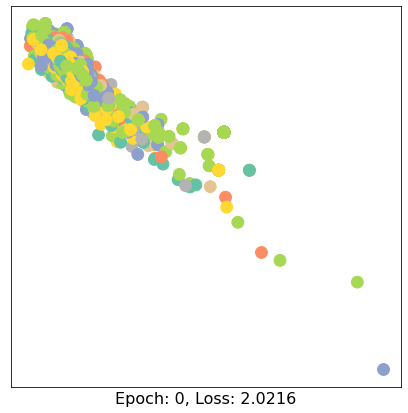

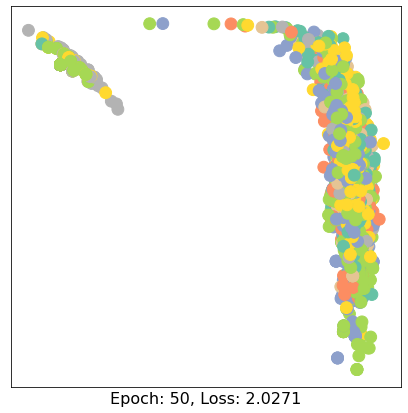

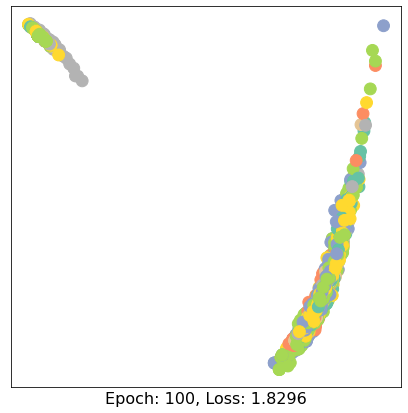

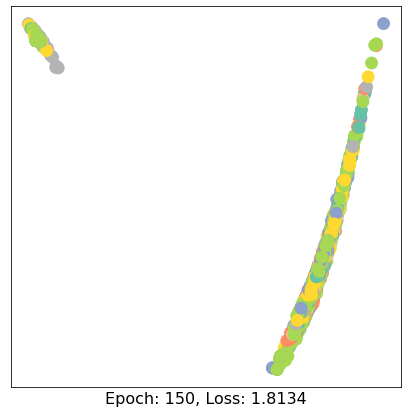

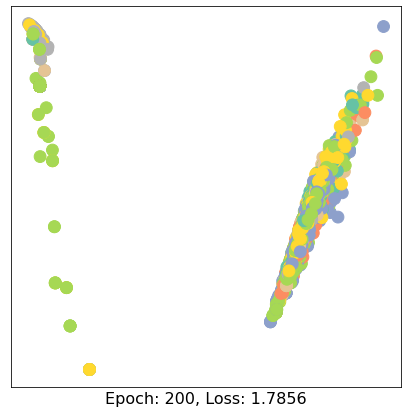

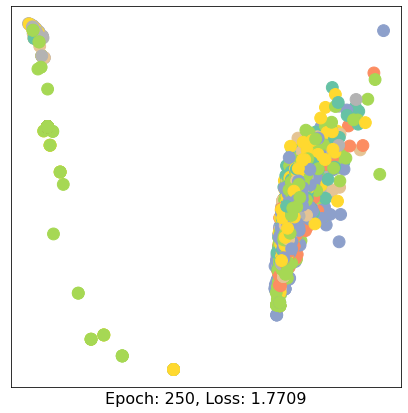

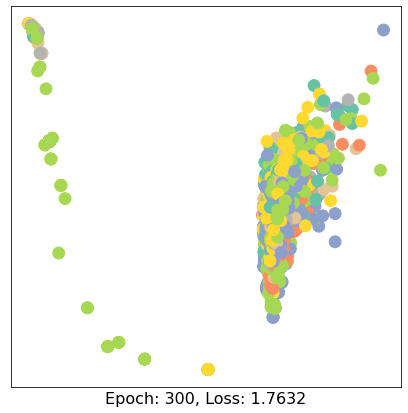

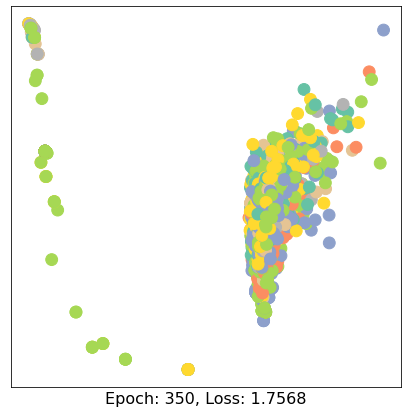

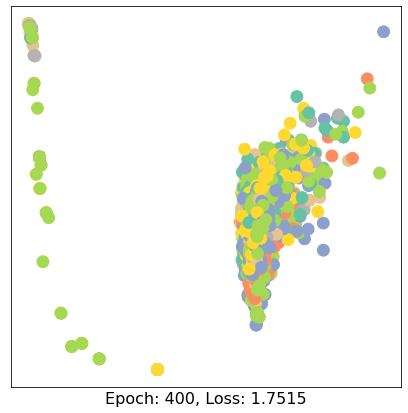

Training learnt nx stat implementation
Node statistics learning accuracy: 65.2983


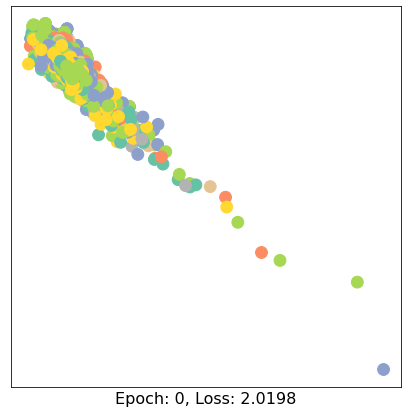

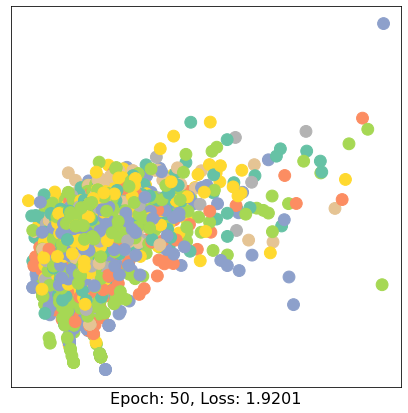

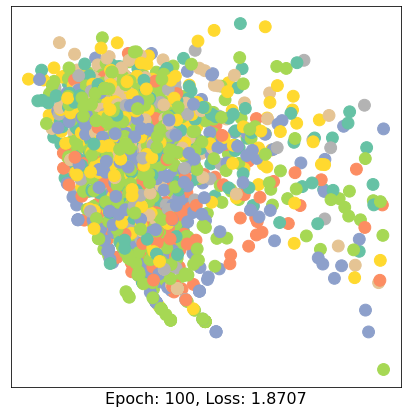

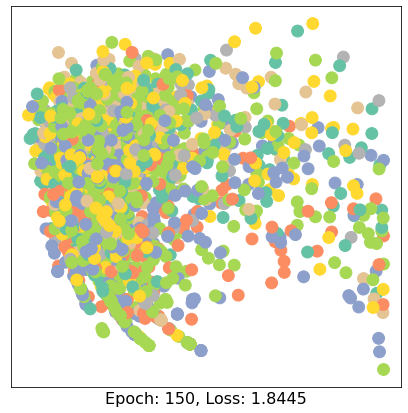

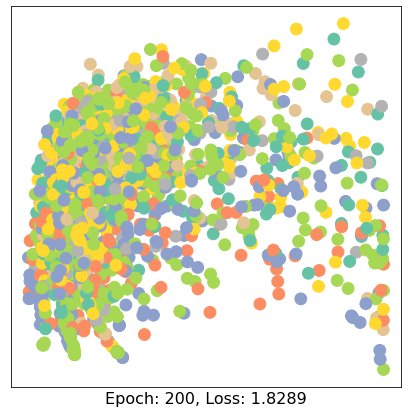

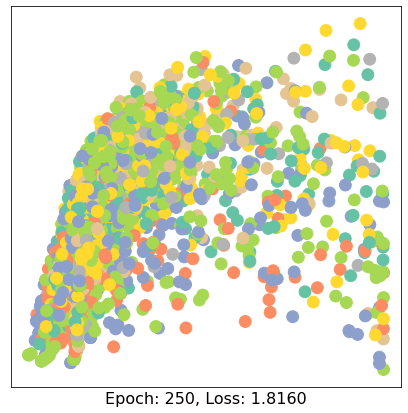

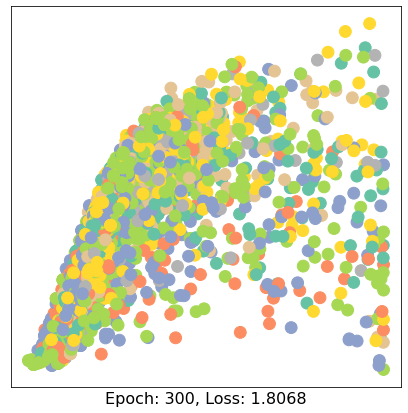

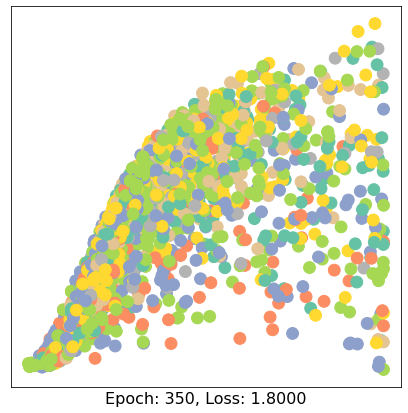

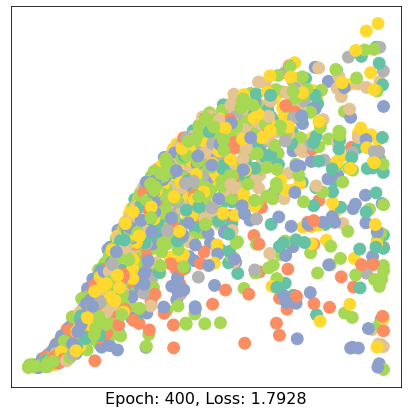

Dataset                          Method  Accuracy
0  Cora()          Vanilla Implementation   47.6636
1  Cora()    Pure NX Stats Implementation   18.6137
2  Cora()  Learnt NX Stats Implementation   15.2259

In [ ]:
CompareTriplets(Planetoid(root="delete_me/", name="Cora")).execute()

## Compare node embeddings on CiteSeer

In [ ]:
class Hyperparameters:
    """
        Setting the best hyperparameters observed during experiments on the node embedding learning model on CiteCeer
    """
    ALL_STATISTICS_CAPTURED: List[str] = ['degree_centrality', 'in_degree_centrality',
                                          'eigenvector_centrality', 'harmonic_centrality',
                                          'closeness_centrality', 'betweenness_centrality', 'load_centrality',
                                          'clustering']

    EMBEDDINGS_SIZE: int = 8
    LEARNING_RATE: float = 0.010
    WEIGHT_DECAY: float = 0.00100
    TRAINING_RATIO: float = 0.8
    DATASET: str = "CiteSeer"
    EPOCHS: int = 250
    ERROR_THRESHOLD: torch.FloatTensor = torch.FloatTensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 10])

Training Vanilla


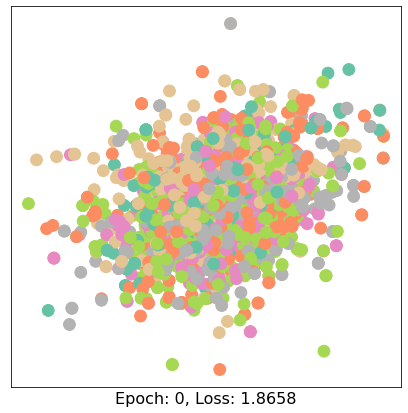

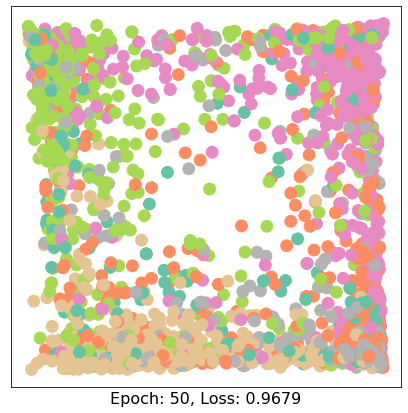

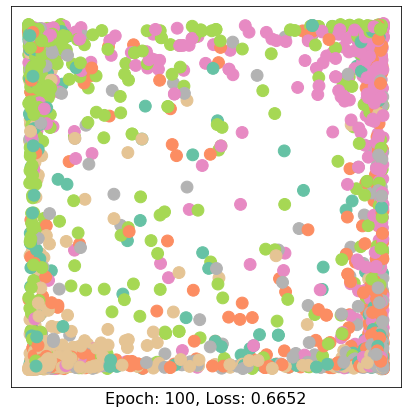

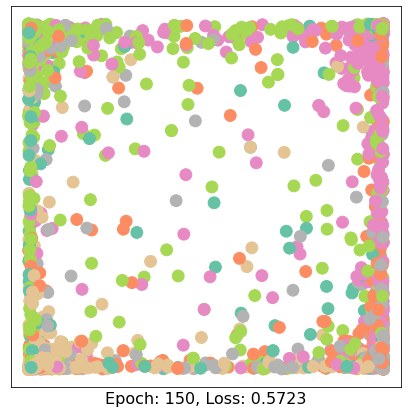

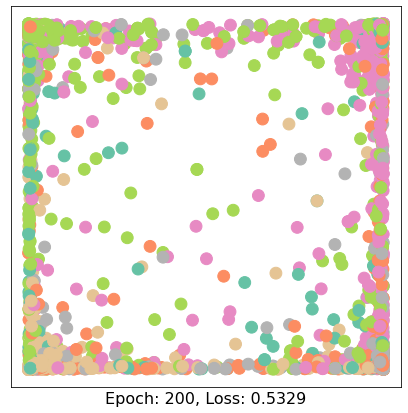

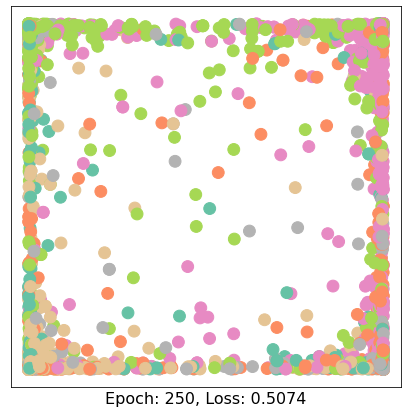

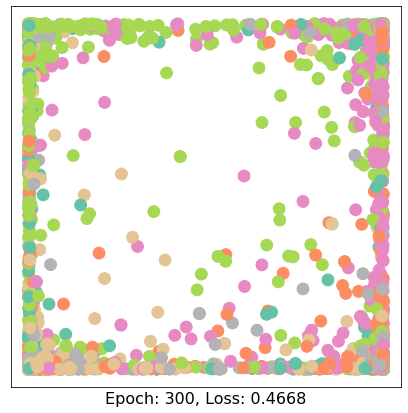

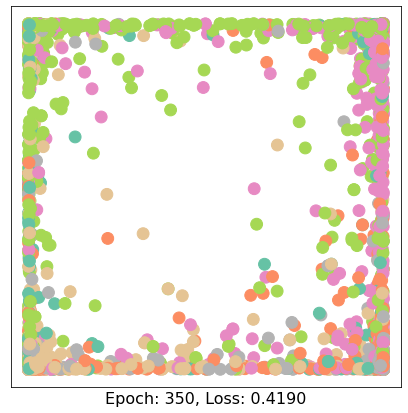

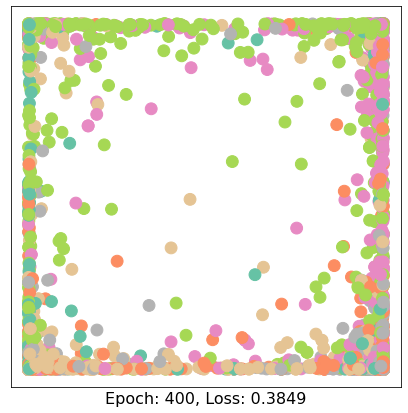

Training Pure nx stat implementation


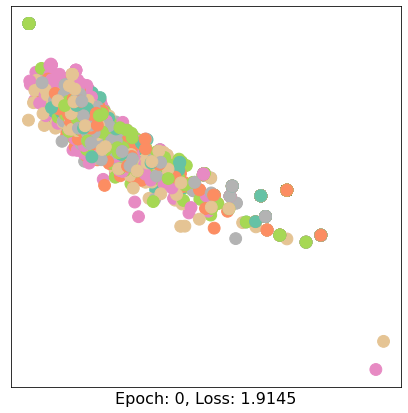

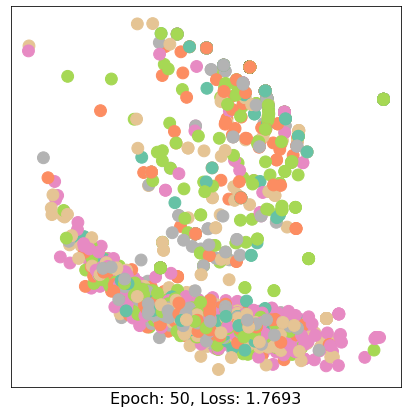

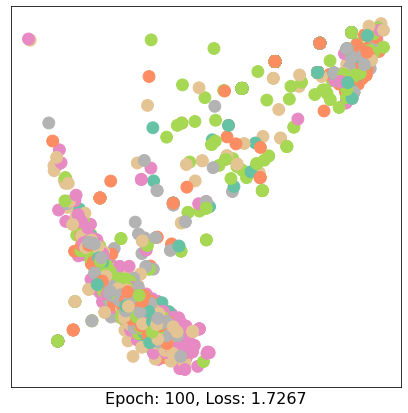

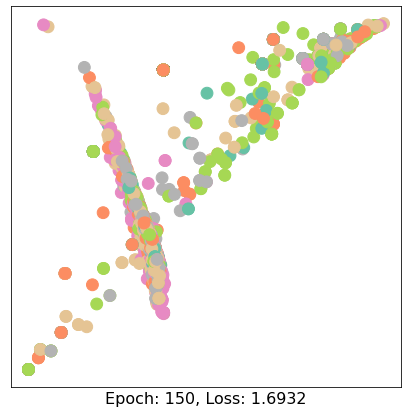

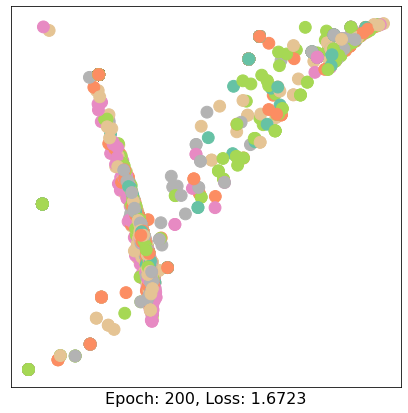

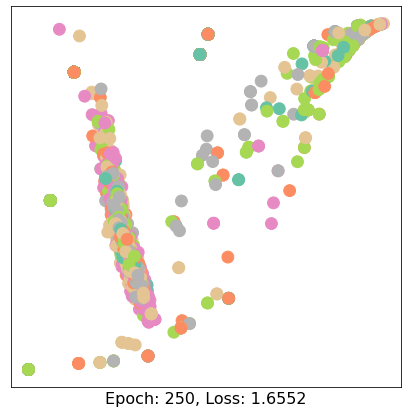

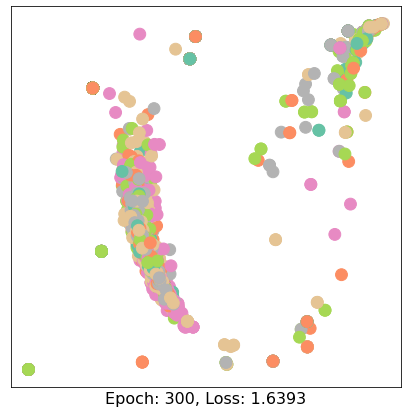

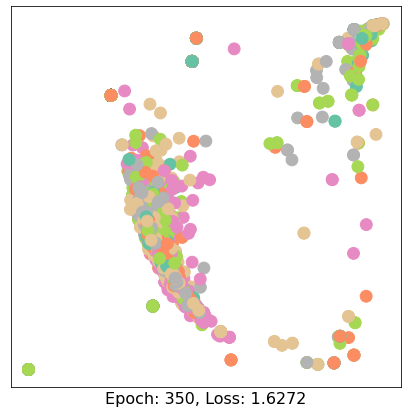

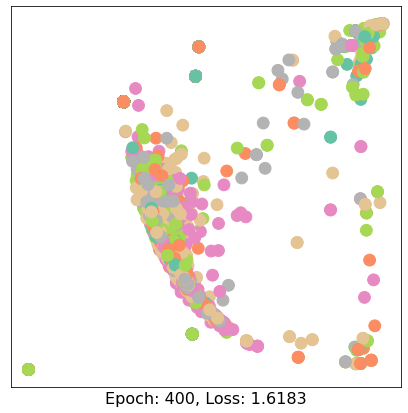

Training learnt nx stat implementation
Node statistics learning accuracy: 55.5556


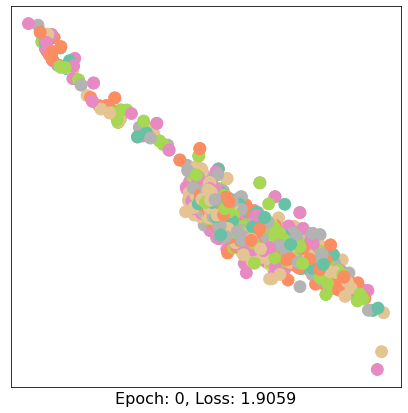

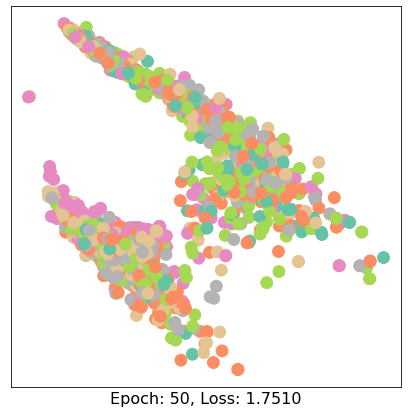

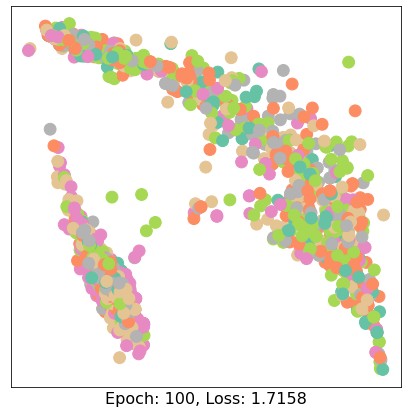

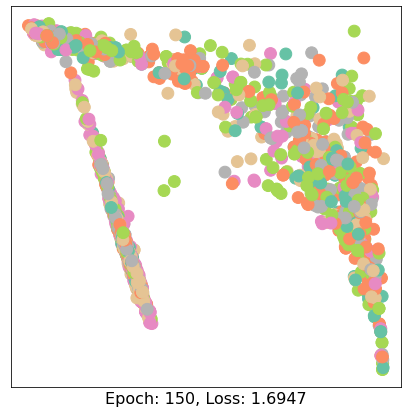

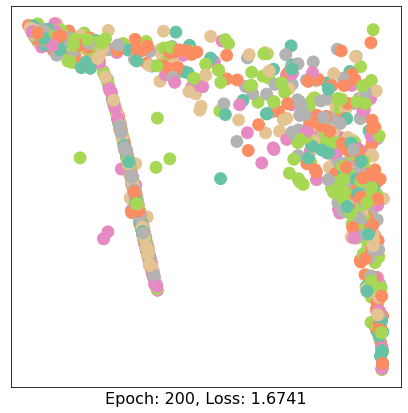

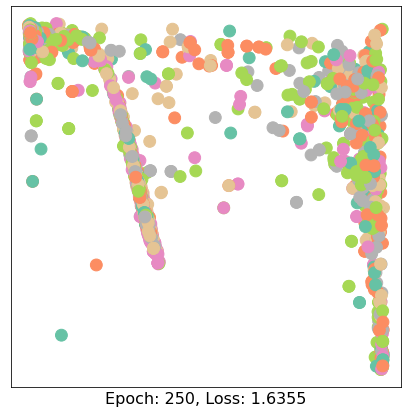

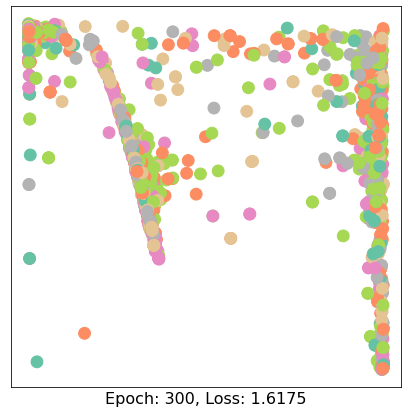

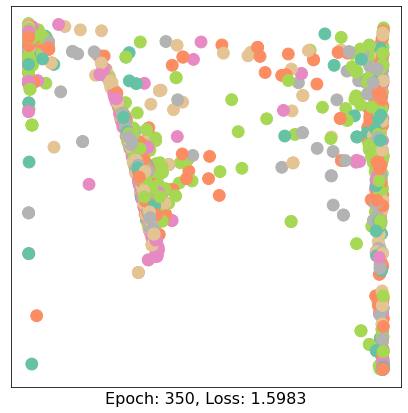

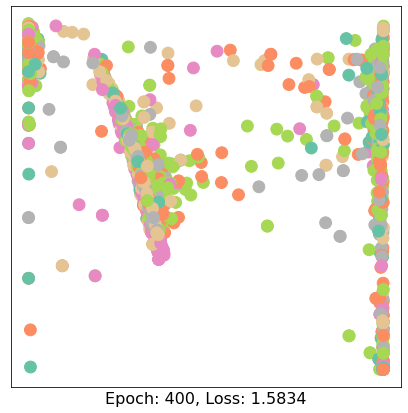

Dataset                          Method  Accuracy
0  CiteSeer()          Vanilla Implementation   40.5363
1  CiteSeer()    Pure NX Stats Implementation   22.7315
2  CiteSeer()  Learnt NX Stats Implementation   22.9810

In [ ]:
CompareTriplets(Planetoid(root="delete_me/", name="CiteSeer")).execute()

Interestingly, in this case the learnt nx stats(row 3) performed better than synthetically nx generated API one(row 2) albeit only marginally better.

# Inferences
It seems that by preliminary analysis, the node statistic embeddings learnt do not fare well in the task of node classification

This could be due to a variety of reasons:
1. The custom accuracy function defined in the previous section is highly inaccurate or needs better tuning
2. The set of statistics captured is a bad combination / there is a lack of it captured(more dimensions?)
4. Better tuned hyperparameters during training of node statistics model(as seen in the case of CiteSeer on node classification)
3. Node statistics could be better utilized in some other downstream task such as link prediction

*One silver lining is that, accuracies of both the pure nx implementation and the learnt nx stats implementation in the downstream task are close to each other. This implies that the node statistic learning GNN model was successfull in approximating note statistic embeddings. But is the node embedding learnt this way useful remains unanswered*